In [147]:
from database.market import Market
from database.adatabase import ADatabase
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [148]:
market = Market()

In [149]:
financial_db = ADatabase("strategy_financial")

In [185]:
market.connect()
sp5 = market.retrieve("sp500")
financials = market.retrieve("financial_set")
market.disconnect()

In [186]:
financials = p.column_date_processing(financials)

In [187]:
factors = [x for x in financials.columns if x not in ["ticker","year","quarter","close"]]

In [406]:
factors

['assets',
 'liabilitiesandstockholdersequity',
 'incometaxexpensebenefit',
 'retainedearningsaccumulateddeficit',
 'accumulatedothercomprehensiveincomelossnetoftax',
 'earningspersharebasic',
 'earningspersharediluted',
 'propertyplantandequipmentnet',
 'cashandcashequivalentsatcarryingvalue',
 'entitycommonstocksharesoutstanding',
 'weightedaveragenumberofdilutedsharesoutstanding',
 'weightedaveragenumberofsharesoutstandingbasic',
 'stockholdersequity']

In [322]:
spy = pd.read_csv("./csv_files/SPY.csv")

In [323]:
spy = p.column_date_processing(spy)

In [324]:
spy["year"] = [x.year for x in spy["date"]]
spy["quarter"] = [x.quarter for x in spy["date"]]
spy_quarterly = spy.groupby(["year","quarter"]).mean().reset_index()

In [329]:
spy.dtypes

date        datetime64[ns]
open               float64
high               float64
low                float64
close              float64
adjclose           float64
volume               int64
year                 int64
quarter              int64
dtype: object

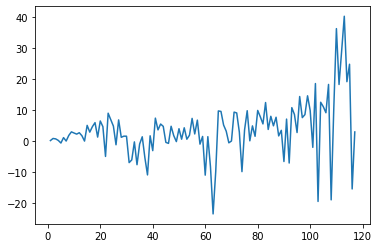

In [318]:
plt.plot(spy_quarterly["diff"])

In [191]:
fed_fund = pd.read_csv("./csv_files/FEDFUNDS.csv")
fed_fund = p.column_date_processing(fed_fund)
fed_fund["year"] = [x.year for x in fed_fund["date"]]
fed_fund["quarter"] = [x.quarter for x in fed_fund["date"]]
fed_fund_quarterly = fed_fund.groupby(["year","quarter"]).mean().reset_index()

In [385]:
cpi = pd.read_csv("./csv_files/CPIAUCSL.csv")
cpi = p.column_date_processing(cpi)
cpi["year"] = [x.year for x in cpi["date"]]
cpi["quarter"] = [x.quarter for x in cpi["date"]]
cpi_quarterly = cpi.groupby(["year","quarter"]).mean().reset_index()
cpi_quarterly.rename(columns={"cpiaucsl":"cpi"},inplace=True)
cpi_quarterly["inflation"] = cpi_quarterly["cpi"].pct_change()
cpi_quarterly

,year,quarter,cpi,inflation
0,1947,1,21.700000,NaN
1,1947,2,22.010000,0.014286
2,1947,3,22.490000,0.021808
3,1947,4,23.126667,0.028309
4,1948,1,23.616667,0.021188
...,...,...,...,...
297,2021,2,268.760333,0.019868
298,2021,3,273.163333,0.016383
299,2021,4,278.413333,0.019219
300,2022,1,284.607667,0.022249


In [426]:
discount = pd.read_csv("./csv_files/DISCOUNTRATE.csv")
discount = p.column_date_processing(discount)
discount["year"] = [x.year for x in discount["date"]]
discount["quarter"] = [x.quarter for x in discount["date"]]
discount_quarterly = discount.groupby(["year","quarter"]).mean().reset_index()
discount_quarterly.rename(columns={"intdsrusm193n":"discount_rate"},inplace=True)

In [370]:
discount

,date,discount_rate,year,quarter
0,1950-01-01,1.50,1950,1
1,1950-02-01,1.50,1950,1
2,1950-03-01,1.50,1950,1
3,1950-04-01,1.50,1950,2
4,1950-05-01,1.50,1950,2
...,...,...,...,...
855,2021-04-01,0.25,2021,2
856,2021-05-01,0.25,2021,2
857,2021-06-01,0.25,2021,2
858,2021-07-01,0.25,2021,3


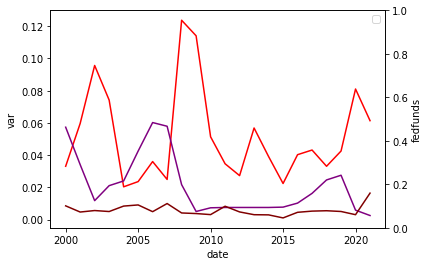

In [388]:
from statistics import variance
var_check = []
for year in range(1993,2022):
    mean = spy[spy["year"]==year]["adjclose"].mean()
    diff = (spy[spy["year"]==year]["adjclose"] - mean) / mean
    diff_squared = [abs(x) for x in diff]
    diff_total = sum(diff_squared)
    var = diff_total / spy[spy["year"]==year]["adjclose"].index.size
    var_check.append({"year":year,"var":var})
var_graph = pd.DataFrame(var_check) \
.merge(fed_fund.groupby("year").mean().reset_index().drop("quarter",axis=1),on=["year"]) \
.merge(discount.groupby("year").mean().reset_index().drop("quarter",axis=1),on=["year"]) \
.merge(cpi_quarterly.groupby("year").mean().reset_index().drop("quarter",axis=1),on=["year"])
var_graph["fedfunds"] = var_graph["fedfunds"]/100
var_graph["discount_rate"] = var_graph["discount_rate"]/100
var_graph["rate_diff"] = var_graph["discount_rate"] - var_graph["fedfunds"]
metric = "prog"
fig,ax = plt.subplots()
ax.plot(var_graph["year"],var_graph["var"],color="red")
ax.set_xlabel("date")
ax.set_ylabel("var")
ax2 = ax.twinx()
# ax.plot(var_graph["year"],var_graph["fedfunds"],color="blue")
ax.plot(var_graph["year"],var_graph["discount_rate"],color="purple")
ax.plot(var_graph["year"],var_graph["inflation"],color="maroon")
# ax2.set_xlabel("date")
ax2.set_ylabel("fedfunds")
plt.legend(["spy","se","cpi"])
plt.show()

In [389]:
var_graph

,year,var,fedfunds,discount_rate,cpi,inflation,rate_diff
0,2000,0.033075,0.062358,0.057325,172.191667,0.008500,-0.005033
1,2001,0.059637,0.038875,0.034100,177.041667,0.004662,-0.004775
2,2002,0.095645,0.016667,0.011733,179.866667,0.005588,-0.004933
3,2003,0.074165,0.011275,0.021042,184.000000,0.004977,0.009767
4,2004,0.020321,0.013492,0.023958,188.908333,0.008358,0.010467
5,2005,0.023557,0.032133,0.042500,195.266667,0.009070,0.010367
6,2006,0.035991,0.049642,0.060208,201.558333,0.004893,0.010567
7,2007,0.024898,0.050192,0.057917,207.344167,0.009932,0.007725
8,2008,0.123720,0.019275,0.021667,215.254250,0.004090,0.002392
9,2009,0.114065,0.001600,0.005000,214.564667,0.003718,0.003400


In [390]:
factors

['assets',
 'liabilitiesandstockholdersequity',
 'incometaxexpensebenefit',
 'retainedearningsaccumulateddeficit',
 'accumulatedothercomprehensiveincomelossnetoftax',
 'earningspersharebasic',
 'earningspersharediluted',
 'propertyplantandequipmentnet',
 'cashandcashequivalentsatcarryingvalue',
 'entitycommonstocksharesoutstanding',
 'weightedaveragenumberofdilutedsharesoutstanding',
 'weightedaveragenumberofsharesoutstandingbasic',
 'stockholdersequity']

In [391]:
financials["liabilities"] = financials["liabilitiesandstockholdersequity"] - financials["stockholdersequity"]
financials_quarterly = financials.groupby(["year","quarter"]).sum().reset_index()

In [392]:
financials_quarterly

,year,quarter,assets,liabilitiesandstockholdersequity,incometaxexpensebenefit,retainedearningsaccumulateddeficit,accumulatedothercomprehensiveincomelossnetoftax,earningspersharebasic,earningspersharediluted,propertyplantandequipmentnet,cashandcashequivalentsatcarryingvalue,entitycommonstocksharesoutstanding,weightedaveragenumberofdilutedsharesoutstanding,weightedaveragenumberofsharesoutstandingbasic,stockholdersequity,liabilities
0,2009,2,2.398783e+11,2.398783e+11,-1.343749e+09,2.875032e+10,-7.037468e+09,7.965000e+00,7.615000e+00,1.640530e+11,1.292005e+10,5.705672e+09,4.947524e+09,4.856231e+09,8.038340e+10,1.594949e+11
1,2009,3,2.280034e+13,2.280481e+13,7.850185e+10,2.508754e+12,-3.788043e+11,2.975087e+02,2.931295e+02,2.421966e+12,1.900197e+12,1.296521e+15,1.389552e+12,1.378473e+12,3.764555e+12,1.904026e+13
2,2009,4,1.240511e+13,1.240511e+13,5.535151e+10,1.508063e+12,-1.990221e+11,1.027717e+06,9.927140e+05,1.334445e+12,1.026465e+12,2.467281e+14,2.706455e+11,2.669637e+11,2.171161e+12,1.023395e+13
3,2010,1,2.346927e+13,2.346927e+13,1.935924e+11,2.893865e+12,-3.730721e+11,6.782866e+02,6.667505e+02,2.684510e+12,2.010455e+12,3.341415e+11,5.277619e+11,5.165850e+11,4.228247e+12,1.924102e+13
4,2010,2,2.535015e+13,2.544121e+13,6.874402e+10,3.024642e+12,-3.798504e+11,2.377044e+02,2.343734e+02,2.708586e+12,2.213084e+12,3.491285e+11,3.240516e+11,3.166629e+11,4.572679e+12,2.086854e+13
5,2010,3,1.042288e+13,1.140704e+13,5.009499e+10,1.508860e+12,-1.998058e+11,2.166309e+02,2.107808e+02,1.393105e+12,1.133289e+12,3.346267e+13,1.765814e+11,1.728858e+11,2.283310e+12,9.123731e+12
6,2010,4,1.057970e+13,1.168014e+13,6.487963e+10,1.551156e+12,-1.732164e+11,3.057274e+02,2.997300e+02,1.492188e+12,1.136214e+12,1.845103e+11,1.736033e+11,1.709339e+11,2.359998e+12,9.320143e+12
7,2011,1,8.406458e+12,8.805465e+12,7.310142e+10,1.582441e+12,-1.480116e+11,3.066911e+02,3.005502e+02,1.358661e+12,1.076241e+12,1.045955e+12,1.662235e+11,1.654106e+11,2.377321e+12,6.428144e+12
8,2011,2,1.074127e+13,1.180678e+13,4.932040e+10,1.704859e+12,-1.437277e+11,2.200175e+02,2.132662e+02,1.451707e+12,1.173547e+12,1.947017e+12,1.826350e+11,1.790354e+11,2.483873e+12,9.322905e+12
9,2011,3,1.032873e+13,1.172024e+13,5.804484e+10,1.705139e+12,-1.238828e+11,3.176954e+02,3.093690e+02,1.426702e+12,1.182799e+12,7.655734e+13,1.617803e+11,1.595592e+11,2.479600e+12,9.240640e+12


In [427]:
graphics = financials_window.merge(cpi_quarterly,on=["year","quarter"],how="left") \
                            .merge(fed_fund_quarterly,on=["year","quarter"],how="left") \
                            .merge(discount_quarterly,on=["year","quarter"],how="left") \
                            .merge(spy_quarterly,on=["year","quarter"],how="left").copy()
graphics["date"] = [datetime(int(row[1]["year"]),int((row[1]["quarter"] - 1) * 3 + 1),1) for row in graphics.iterrows()]
graphics = graphics[(graphics["date"]>datetime(2013,1,1))].copy()
graphics.sort_values("date",inplace=True)
graphics["inflation"] = graphics["inflation"]
cpi_prog = [0]
for i in range(1,graphics.index.size):
    prev = cpi_prog[i-1]
    cpi_prog.append((1+prev) * (1 +  graphics["inflation"].iloc[i]) -1) 
graphics["inflation_prog"] = cpi_prog
for vals in ["assets","liabilities","stockholdersequity","spy","cashandcashequivalentsatcarryingvalue"]:
    if vals == "spy":
        graphics[f"{vals}_adj"] = [row[1]["adjclose"] * (1-row[1]["inflation_prog"]) for row in graphics.iterrows()]
    else:
        graphics[f"{vals}_adj"] = [row[1][vals] * (1-row[1]["inflation_prog"]) for row in graphics.iterrows()]
graphics["spy_prog"] = (graphics["adjclose"] - graphics["adjclose"].iloc[0]) / graphics["adjclose"].iloc[0]
graphics["cash_prog"] = (graphics["cashandcashequivalentsatcarryingvalue"] - graphics["cashandcashequivalentsatcarryingvalue"].iloc[0]) / graphics["cashandcashequivalentsatcarryingvalue"].iloc[0]
graphics["se_prog"] = (graphics["stockholdersequity"] - graphics["stockholdersequity"].iloc[0]) / graphics["stockholdersequity"].iloc[0]
graphics["assets_prog"] = (graphics["assets"] - graphics["assets"].iloc[0]) / graphics["assets"].iloc[0]
graphics["liabilities_prog"] = (graphics["liabilities"] - graphics["liabilities"].iloc[0]) / graphics["liabilities"].iloc[0]
graphics["spy_delt"] = graphics["spy_prog"].pct_change()
graphics["se_delt"] = graphics["se_prog"].pct_change()
graphics["assets_delt"] = graphics["assets_prog"].pct_change()
graphics["cash_delt"] = graphics["cash_prog"].pct_change()
graphics["liabilities_delt"] = graphics["liabilities_prog"].pct_change()
graphics["cash_prog_adj"] = (graphics["cashandcashequivalentsatcarryingvalue_adj"] - graphics["cashandcashequivalentsatcarryingvalue_adj"].iloc[0]) / graphics["cashandcashequivalentsatcarryingvalue_adj"].iloc[0]
graphics["spy_prog_adj"] = (graphics["spy_adj"] - graphics["spy_adj"].iloc[0]) / graphics["spy_adj"].iloc[0]
graphics["se_prog_adj"] = (graphics["stockholdersequity_adj"] - graphics["stockholdersequity_adj"].iloc[0]) / graphics["stockholdersequity_adj"].iloc[0]
graphics["assets_prog_adj"] = (graphics["assets_adj"] - graphics["assets_adj"].iloc[0]) / graphics["assets_adj"].iloc[0]
graphics["liabilities_prog_adj"] = (graphics["liabilities_adj"] - graphics["liabilities_adj"].iloc[0]) / graphics["liabilities_adj"].iloc[0]
graphics["spy_delt_adj"] = graphics["spy_prog"].pct_change()
graphics["se_delt_adj"] = graphics["se_prog"].pct_change()
graphics["assets_delt_adj"] = graphics["assets_prog"].pct_change()
graphics["liabilities_delt_adj"] = graphics["liabilities_prog"].pct_change()
graphics["cash_delt_adj"] = graphics["cash_prog"].pct_change()
graphics["cpi_delt"] = graphics["inflation_prog"].pct_change()

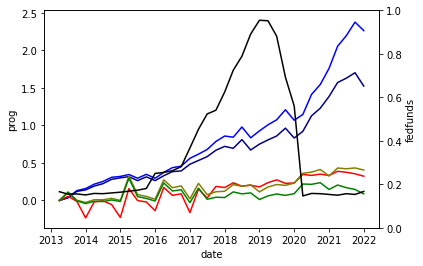

In [428]:
metric = "prog"
fig,ax = plt.subplots()
ax.plot(graphics["date"],graphics[f"spy_{metric}"],color="blue")
ax.plot(graphics["date"],graphics[f"spy_{metric}_adj"],color="navy")
# ax.plot(graphics["date"],graphics[f"assets_{metric}"],color="maroon")
ax.plot(graphics["date"],graphics[f"assets_{metric}_adj"],color="red")
ax.plot(graphics["date"],graphics[f"cash_{metric}"],color="olive")
ax.plot(graphics["date"],graphics[f"cash_{metric}_adj"],color="green")
# ax.plot(graphics["date"],graphics[f"liabilities_{metric}"],color="maroon")
# ax.plot(graphics["date"],graphics[f"liabilities_{metric}_adj"],color="red")
# ax.plot(graphics["date"],graphics[f"assets_{metric}"],color="navy")
# ax.plot(graphics["date"],graphics[f"assets_{metric}_adj"],color="blue")
ax.set_xlabel("date")
ax.set_ylabel("prog")
ax2 = ax.twinx()
# ax2.plot(graphics["date"],graphics[f"cpi_{metric}"],color="blue")
ax.plot(graphics["date"],graphics["fedfunds"],color="black")
ax2.set_xlabel("date")
ax2.set_ylabel("fedfunds")
# plt.legend(["spy","se","cpi"])
plt.show()

In [424]:
graphics.columns

Index(['year', 'quarter', 'assets', 'liabilitiesandstockholdersequity',
       'incometaxexpensebenefit', 'retainedearningsaccumulateddeficit',
       'accumulatedothercomprehensiveincomelossnetoftax',
       'earningspersharebasic', 'earningspersharediluted',
       'propertyplantandequipmentnet', 'cashandcashequivalentsatcarryingvalue',
       'entitycommonstocksharesoutstanding',
       'weightedaveragenumberofdilutedsharesoutstanding',
       'weightedaveragenumberofsharesoutstandingbasic', 'stockholdersequity',
       'liabilities', 'date', 'cpi', 'inflation', 'fedfunds', 'intdsrusm193n',
       'open', 'high', 'low', 'close', 'adjclose', 'volume', 'inflation_prog',
       'assets_adj', 'liabilities_adj', 'stockholdersequity_adj', 'spy_adj',
       'cashandcashequivalentsatcarryingvalue_adj', 'spy_prog', 'cash_prog',
       'se_prog', 'assets_prog', 'liabilities_prog', 'spy_delt', 'se_delt',
       'assets_delt', 'cash_delt', 'liabilities_delt', 'cash_prog_adj',
       'spy_prog_a

In [429]:
graphics["prog_diff"] = graphics["spy_prog"] - graphics["spy_prog_adj"]
graphics[["date","inflation","inflation_prog","discount_rate","spy_prog","spy_prog_adj","se_prog_adj","assets_prog_adj","liabilities_prog_adj","cash_prog_adj","cash_prog"]]

,date,inflation,inflation_prog,discount_rate,spy_prog,spy_prog_adj,se_prog_adj,assets_prog_adj,liabilities_prog_adj,cash_prog_adj,cash_prog
0,2013-04-01,-0.001095,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-07-01,0.005408,0.005408,0.750000,0.040260,0.034634,0.035407,0.055030,0.054865,0.106944,0.112964
2,2013-10-01,0.003698,0.009126,0.750000,0.131214,0.120891,-0.013446,-0.012047,-0.009689,-0.006029,0.003126
3,2014-01-01,0.006228,0.015411,0.750000,0.158360,0.140509,-0.041323,-0.233163,-0.327453,-0.041883,-0.026887
4,2014-04-01,0.005311,0.020803,0.750000,0.216701,0.191389,0.014673,-0.019873,-0.026055,-0.012007,0.008983
5,2014-07-01,0.002558,0.023415,0.750000,0.252442,0.223116,0.040780,-0.003892,-0.013211,-0.014920,0.008698
6,2014-10-01,-0.002484,0.020872,0.750000,0.308516,0.281204,0.028667,-0.054605,-0.001945,0.006320,0.027773
7,2015-01-01,-0.006473,0.014264,0.750000,0.320321,0.301487,0.028502,-0.227003,-0.300934,-0.013629,0.000645
8,2015-04-01,0.006819,0.021181,0.750000,0.345380,0.316884,0.290086,0.158541,0.213419,0.295833,0.323875
9,2015-07-01,0.003777,0.025038,0.750000,0.296481,0.264020,0.109646,-0.001606,0.039545,0.050838,0.077825


In [413]:
graphics["debt_payability"] = graphics["liabilities_adj"] / graphics["cashandcashequivalentsatcarryingvalue_adj"]

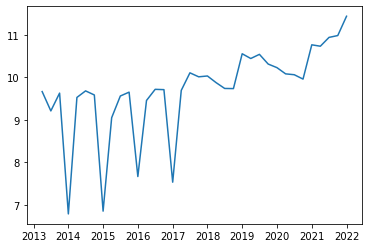

In [414]:
plt.plot(graphics["date"],graphics["debt_payability"])